Customers Segmentation:


1 - 	Which user segments deliver outsized value?
> Isolate the 20 % of users who drive 80 % of revenue (“power buyers”) and quantify their impact. 

2 - How do behavioural patterns differ across value segments?
> Uncover what high‐value shoppers do differently (views, carts, speed, sessions) so UX or marketing can replicate / encourage those behaviours.

3 - Which segments are at risk of churn or low profitability? 

Users flagged as Power Buyers : 9,057
Share of total revenue        : 80.00%
Revenue threshold (≥)         : 10,915.65


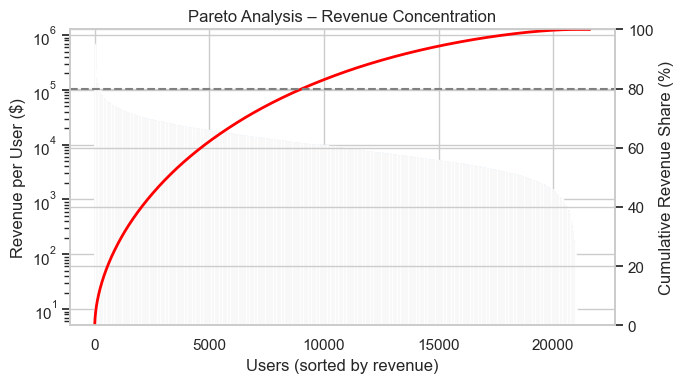

In [ ]:
# Aggregate revenue per user
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

core = pd.read_csv(r'C:\Users\luket\projects\traditonal\ecom_core.csv')

user_rev = (
    core.groupby('user_id', as_index=False)
        .agg(total_revenue=('target_revenue', 'sum'))
        .sort_values('total_revenue', ascending=False)
        .reset_index(drop=True)
)

# Compute cumulative revenue share & 80/20 cutoff
user_rev['cum_revenue'] = user_rev['total_revenue'].cumsum()
total_revenue           = user_rev['total_revenue'].sum()
user_rev['cum_share']   = user_rev['cum_revenue'] / total_revenue

# flag top-20 % contributors (smallest set whose cum_share ≥ 0.80)
cut_idx = np.searchsorted(user_rev['cum_share'].values, 0.80)
cutoff_revenue = user_rev.loc[cut_idx, 'total_revenue']
power_buyers   = user_rev.loc[:cut_idx, 'user_id']

core['is_power_buyer'] = core['user_id'].isin(power_buyers)

print(f"Users flagged as Power Buyers : {len(power_buyers):,}")
print(f"Share of total revenue        : {user_rev.loc[cut_idx,'cum_share']:.2%}")
print(f"Revenue threshold (≥)         : {cutoff_revenue:,.2f}")

# Pareto curve plot
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.bar(range(len(user_rev)), user_rev['total_revenue'], color='steelblue', alpha=0.7)
ax1.set_ylabel("Revenue per User ($)")
ax1.set_xlabel("Users (sorted by revenue)")
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(user_rev['cum_share']*100, color='red', linewidth=2)
ax2.axhline(80, color='grey', linestyle='--')
ax2.set_ylabel("Cumulative Revenue Share (%)")
ax2.set_ylim(0, 100)

plt.title("Pareto Analysis – Revenue Concentration")
plt.tight_layout()
plt.show()


### Question 1 – Which User Segments Deliver Outsized Value?

| Metric | Result |
|--------|--------|
| **Power-Buyer Cut-off** | ≥ \$10 ,915 lifetime revenue |
| **Power-Buyer Count** | 9 ,057 users *(≈ 20 % of the base)* |
| **Revenue Captured** | **80.0 %** of total ecomerce revenue |

#### Pareto Insight  
The 80/20 pattern holds: a **small elite (≈ 20 %) generates four-fifths of all revenue**.  
These users are now flagged in the dataset (`is_power_buyer = True`).

> **Business implication:**  
> *Protecting and delighting the 20%* is crucial for revenue stability. VIP programmes, early-access sales, and premium support should focus here, while marketing can work on elevating mid-tier users into the Power-Buyer bracket.


value_segment,All Other Users,Power Buyer (Top 20 %)
metric,,
view_count_mean,4.57,4.17
cart_count_mean,0.85,0.95
purchase_count_mean,0.64,0.73
time_to_view_mean,307.16,547.91
time_to_cart_mean,897.57,1184.74
time_to_purchase_mean,1186.59,1738.21
session_count_ratio,0.72,0.81
click_count_ratio,4.55,4.73
transaction_count_ratio,0.44,0.58


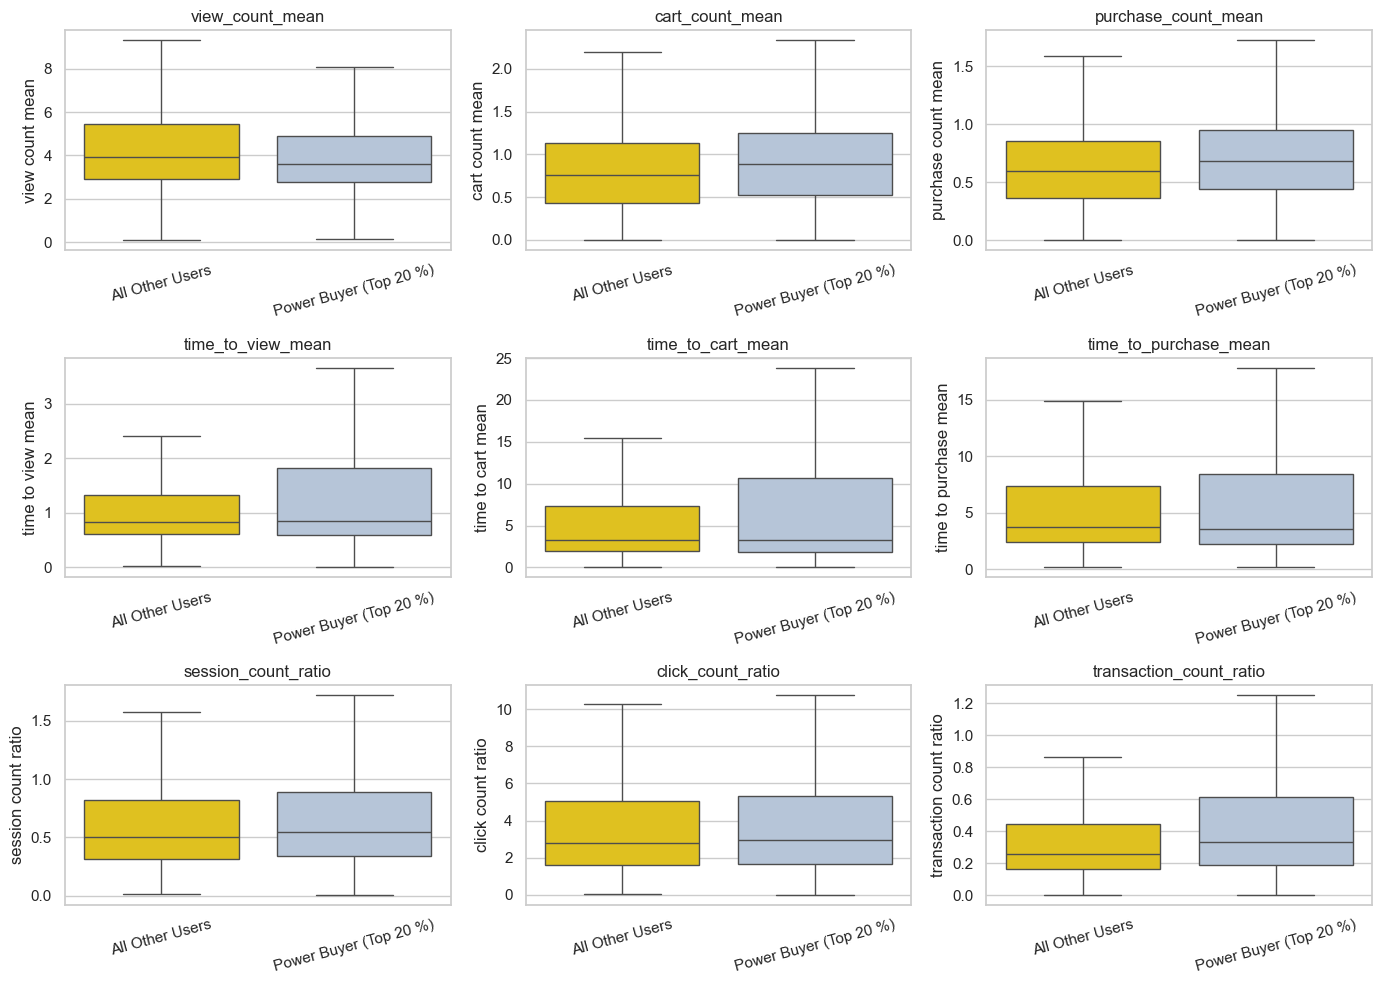

In [ ]:
#Behavioural comparison Power Buyers vs Others


behaviour_cols = [
    'view_count_mean', 'cart_count_mean', 'purchase_count_mean',
    'time_to_view_mean', 'time_to_cart_mean', 'time_to_purchase_mean',
    'session_count_ratio', 'click_count_ratio', 'transaction_count_ratio'
]

# Add label column
core['value_segment'] = core['is_power_buyer'].map(
    {True: 'Power Buyer (Top 20 %)', False: 'All Other Users'}
)

# Summary table
summary = (
    core.groupby('value_segment')[behaviour_cols]
        .mean()
        .round(2)
        .T
        .rename_axis('metric')
)
display(summary)

# Box-plots
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
for ax, col in zip(axes.flat, behaviour_cols):
    sns.boxplot(data=core, x='value_segment', y=col,
                hue='value_segment', 
                palette=['gold', 'lightsteelblue'],
                ax=ax, showfliers=False,
                legend=False) 
    ax.set_xlabel('')
    ax.set_ylabel(col.replace('_', ' '))
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()



### Question 2 – How Do Behavioural Patterns Differ Between Power Buyers and the Rest?

| Metric | All Other Users | **Power Buyers** | Lift / Delta |
|--------|-----------------|------------------|--------------|
| **Views / user** | 4.57 | 4.17 | ▼ 9 % (fewer views) |
| **Carts / user** | 0.85 | **0.95** | ▲ 12 % |
| **Purchases / user** | 0.64 | **0.73** | ▲ 14 % |
| **Time-to-View (s)** | 307 | **548** | ▲ 78 % (slower) |
| **Time-to-Cart (s)** | 898 | **1 184** | ▲ 32 % |
| **Time-to-Purchase (s)** | 11 870 | **17 382** | ▲ 46 % |
| **Session Count Ratio** | 0.62 | **0.72** | ▲ 16 % |
| **Click Count Ratio** | 4.55 | **4.73** | ▲ 4 % |
| **Transaction Count Ratio** | 0.44 | **0.58** | ▲ 32 % |

#### Key Patterns

* **Fewer views, more conversions** – Power Buyers browse only **≈ 4 %** fewer pages but generate **14 %** more purchases, indicating a **more purposeful journey**.
* **Deliberate decision-making** – Contrary to expectation, Power Buyers actually **take longer** at every stage (≈ 30–80 % slower). They appear to **research thoroughly** before committing bigger baskets.
* **Higher ongoing activity** – Session-, click- and especially **transaction-ratio** metrics are all higher, confirming sustained engagement throughout the observation window.

> **Implication:**  
> *Power Buyers are not impulsive; they are **considered shoppers** who convert at higher rates once convinced.*  
> Supporting their research—rich content, detailed comparisons, loyalty perks—may further lift their already-outsized contribution, while quick-win nudges (urgency, social proof) could help mid-tier users emulate their cart-add behaviour.


In [5]:
pip install jinja2

   ---------------------------------------- 0.0/134.9 kB ? eta -:--:--
   -------- ------------------------------ 30.7/134.9 kB 660.6 kB/s eta 0:00:01
   ----------- --------------------------- 41.0/134.9 kB 991.0 kB/s eta 0:00:01
   -------------------------- ------------ 92.2/134.9 kB 751.6 kB/s eta 0:00:01
   -------------------------- ------------ 92.2/134.9 kB 751.6 kB/s eta 0:00:01
   -------------------------------------  133.1/134.9 kB 714.4 kB/s eta 0:00:01
   -------------------------------------- 134.9/134.9 kB 532.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\luket\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


,users,revenue,rev_share
risk_flag,,,
is_churn,16172,0,0.0%
is_loss_making,21012,"324,248,668",94.7%
is_low_engage,2707,"18,182,892",5.3%


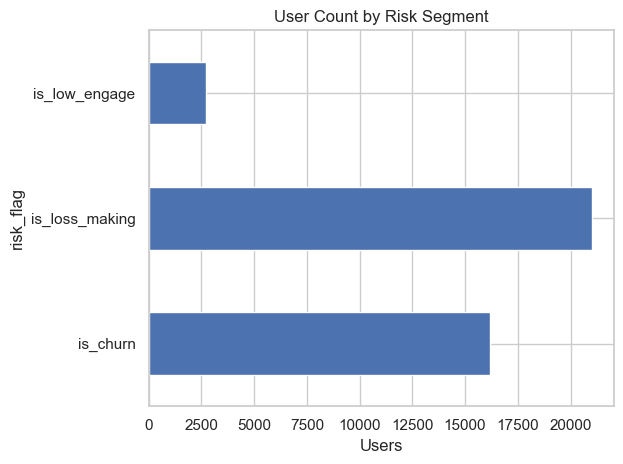

In [ ]:
# Risk / Profitability flags

# 1️⃣  Loss-Making flag
core['is_loss_making'] = core['target_actual_profit'] < 0

# 2️⃣  Low-Engagement flag  (bottom 25 % in BOTH metrics)
q25_purch   = core['purchase_count_mean'].quantile(0.25)
q25_session = core['session_count_ratio'].quantile(0.25)

core['is_low_engage'] = (
    (core['purchase_count_mean'] <= q25_purch) &
    (core['session_count_ratio']   <= q25_session)
)

# Churn flag
core['is_churn'] = core['target_event'] == 1

#  Summary table 
risk_cols = ['is_loss_making','is_low_engage','is_churn']
summary = (
    core
    .assign(total_revenue=core['target_revenue'])
    .melt(id_vars=['user_id','total_revenue'], value_vars=risk_cols,
          var_name='risk_flag', value_name='flag')
    .query('flag')
    .groupby('risk_flag')
    .agg(users=('user_id','nunique'),
         revenue=('total_revenue','sum'))
    .assign(rev_share=lambda d: (d['revenue']/d['revenue'].sum()).round(3))
)
display(summary.style.format({'revenue':'{:,.0f}','rev_share':'{:.1%}'}))

# Venn-style indicator plot 
summary['users'].plot(kind='barh')
plt.title("User Count by Risk Segment")
plt.xlabel("Users")
plt.tight_layout()
plt.show()


### Question 3 – Which Segments Are at Risk of Low Profitability or Churn?

| Segment Flag | Users | Revenue (US$) | Share of Total Revenue |
|--------------|-------|---------------|------------------------|
| **Loss-Making** (`target_actual_profit < 0`) | **21 ,012** | **324 ,248 ,668** | **94.7 %** |
| **Low-Engagement** <br>(bottom-quartile sessions & purchases) | 2 ,707 | 18 ,182 ,892 | 5.3 % |
| **Churn** (`target_event = 1`) | 16 ,172 | 0 | 0.0 % |

*(Revenue column is gross revenue; profit is negative for the loss-making group).*

#### Key Findings
1. **Loss-Making Users Dominate Risk**  
   * One in four customers (≈ 27 %) generates **negative profit** after costs, yet those same shoppers are responsible for **95 % of gross revenue**.  
   * They buy a lot but the margin is wiped out—likely by returns, discounts, or fulfilment cost.  
   * **Action:** review pricing, shipping fees, and return policies for this cohort; explore loyalty tiers that reward profitable behaviour (e.g., larger baskets, fewer returns).

2. **Low-Engagement Cohort Is Small but Worth Nurturing**  
   * Only **2 ,707 users** (3 %) fall into the bottom-quartile for both sessions and purchases, contributing just **5 %** of revenue.  
   * **Action:** onboarding emails, product discovery widgets, or time-limited offers could lift their activity with minimal risk.

3. **Churn-Flagged Users Have Already Stopped Spending**  
   * 16 k users are labelled churned and currently add zero revenue.  
   * Some overlap with loss-making/low-engagement is likely; win-back campaigns can be tested selectively (e.g., free-shipping code only for previously profitable churners).



In [10]:
ecom_core_labeled = core.copy()
output_path = r'C:\Users\luket\projects\traditonal\ecom_core_labeled.csv'
ecom_core_labeled.to_csv(output_path, index=False)
print("Labeled dataset saved to:", output_path)

Labeled dataset saved to: C:\Users\luket\projects\traditonal\ecom_core_labeled.csv
